In [35]:
import kagglehub

# Download latest version of the iot sensor dataset
path = kagglehub.dataset_download("joebeachcapital/metropt-3-dataset")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\joebeachcapital\metropt-3-dataset\versions\1


In [36]:
import pandas as pd
from tqdm import tqdm

file_path = f"{path}/MetroPT3(AirCompressor).csv"  #file path and name
chunksize = 200_000
df_list = []

failure_windows = [
    ('2020-04-18 00:00:00', '2020-04-18 23:59:59'), 
    ('2020-05-29 23:30:00', '2020-05-30 06:00:00'), 
    ('2020-06-05 10:00:00', '2020-06-07 14:30:00'), 
    ('2020-07-15 14:30:00', '2020-07-15 19:00:00')
]

print("Loading, cleaning and labeling dataset...\n")

for i, chunk in enumerate(tqdm(pd.read_csv(file_path, parse_dates=['timestamp'], chunksize=chunksize), 
                                desc="Processing chunks")):
    # ========================
    # BASIC CLEANING
    # ========================
    chunk.drop_duplicates(inplace=True)
    
    # Drop rows with missing values
    chunk.dropna(inplace=True)
    
    # Drop constant columns
    constant_cols = [col for col in chunk.columns if chunk[col].nunique() == 1]
    chunk.drop(columns=constant_cols, inplace=True)
    
    # Remove unrealistic values (example thresholds)
    if 'TP2' in chunk.columns:
        chunk = chunk[(chunk['TP2'] >= 0) & (chunk['TP2'] <= 15)]
    if 'Motor_current' in chunk.columns:
        chunk = chunk[(chunk['Motor_current'] >= 0) & (chunk['Motor_current'] <= 15)]
    
    # ========================
    # LABEL FAILURES
    # ========================
    chunk['label'] = 0
    for start, end in failure_windows:
        mask = (chunk['timestamp'] >= pd.to_datetime(start)) & (chunk['timestamp'] <= pd.to_datetime(end))
        chunk.loc[mask, 'label'] = 1

    df_list.append(chunk)

# ========================
# COMBINE CHUNKS
# ========================
df = pd.concat(df_list, ignore_index=True).drop_duplicates()

# Sort by timestamp
df.sort_values('timestamp', inplace=True)

print(f"\nFinal Shape: {df.shape}")
print(f"Min timestamp: {df['timestamp'].min()}")
print(f"Max timestamp: {df['timestamp'].max()}")
print("\nClass distribution:\n", df['label'].value_counts(normalize=True))


Loading, cleaning and labeling dataset...



Processing chunks: 8it [00:15,  1.95s/it]



Final Shape: (241474, 18)
Min timestamp: 2020-02-01 00:23:17
Max timestamp: 2020-09-01 03:47:17

Class distribution:
 label
0    0.876525
1    0.123475
Name: proportion, dtype: float64


Shape: (241474, 18)

Columns: ['Unnamed: 0', 'timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'label', 'Oil_level', 'Caudal_impulses']

Data Types:
 Unnamed: 0                  int64
timestamp          datetime64[ns]
TP2                       float64
TP3                       float64
H1                        float64
DV_pressure               float64
Reservoirs                float64
Oil_temperature           float64
Motor_current             float64
COMP                      float64
DV_eletric                float64
Towers                    float64
MPG                       float64
LPS                       float64
Pressure_switch           float64
label                       int64
Oil_level                 float64
Caudal_impulses           float64
dtype: object

Missing Values:
 Unnamed: 0             0
timestamp              0
TP2                    0
TP3               

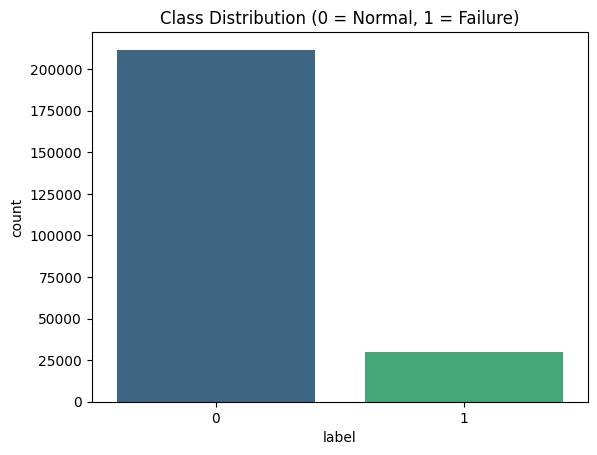

In [37]:
#Overview & Data Structure
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Basic Info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isna().sum())

# Statistical Summary
print("\nStatistical Summary:\n", df.describe())

# Class Balance
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Distribution (0 = Normal, 1 = Failure)')
plt.show()


In [40]:
#Handle Missing Values
# Checking proportion missing again
missing = df.isnull().mean()*100
print(missing)

# Impute missing values (example: forward-fill, then median)
df['Oil_level'].fillna(method='ffill', inplace=True)
df['Oil_level'].fillna(df['Oil_level'].median(), inplace=True)

df['Caudal_impulses'].fillna(method='ffill', inplace=True)
df['Caudal_impulses'].fillna(df['Caudal_impulses'].median(), inplace=True)


Unnamed: 0         0.0
timestamp          0.0
TP2                0.0
TP3                0.0
H1                 0.0
DV_pressure        0.0
Reservoirs         0.0
Oil_temperature    0.0
Motor_current      0.0
COMP               0.0
DV_eletric         0.0
Towers             0.0
MPG                0.0
LPS                0.0
Pressure_switch    0.0
label              0.0
Oil_level          0.0
Caudal_impulses    0.0
dtype: float64


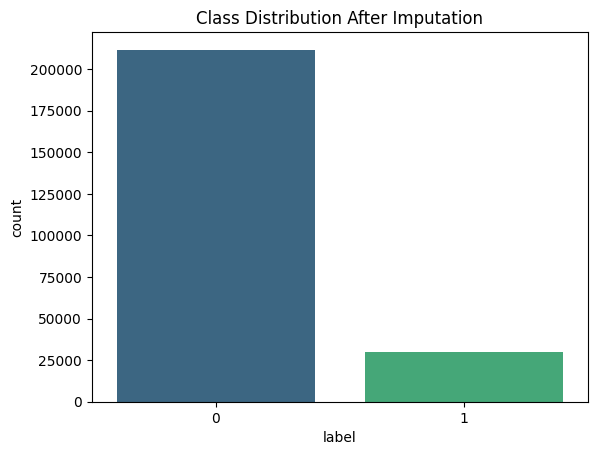

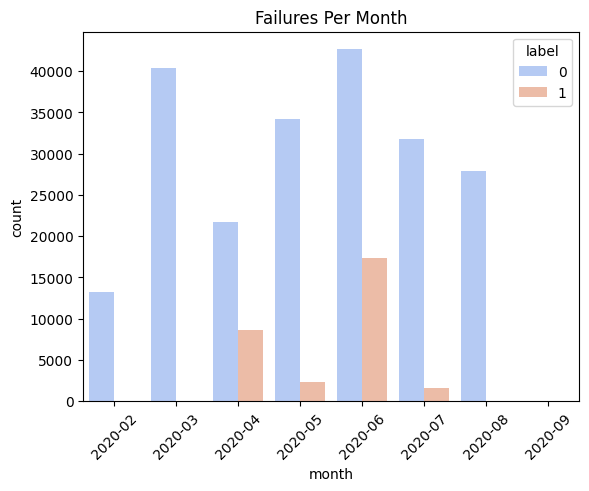

In [7]:
#Updated Class Balance & Temporal Distribution after handling the missing data
# Class balance
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Distribution After Imputation')
plt.show()

# Failures per month
df['month'] = df['timestamp'].dt.to_period('M')
sns.countplot(x='month', hue='label', data=df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Failures Per Month')
plt.show()


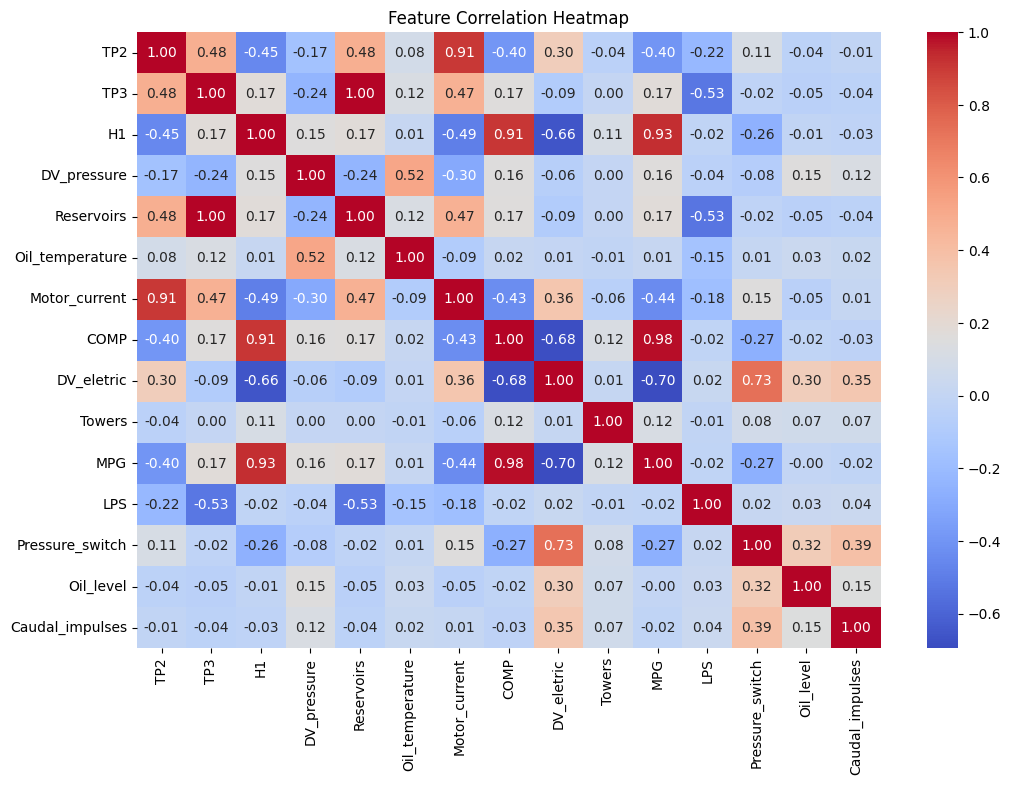

TP3               -0.251179
Reservoirs        -0.250362
Motor_current     -0.187352
TP2               -0.107037
COMP              -0.046844
MPG               -0.046041
H1                -0.043668
Towers            -0.022267
LPS                0.020996
Pressure_switch    0.051980
DV_eletric         0.066573
Caudal_impulses    0.101515
Oil_level          0.114208
Oil_temperature    0.443481
DV_pressure        0.621330
dtype: float64


In [41]:
#Feature Correlations
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop(['label','Unnamed: 0'])

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Correlation with label
corr_with_label = df[num_cols].corrwith(df['label']).sort_values()
print(corr_with_label)


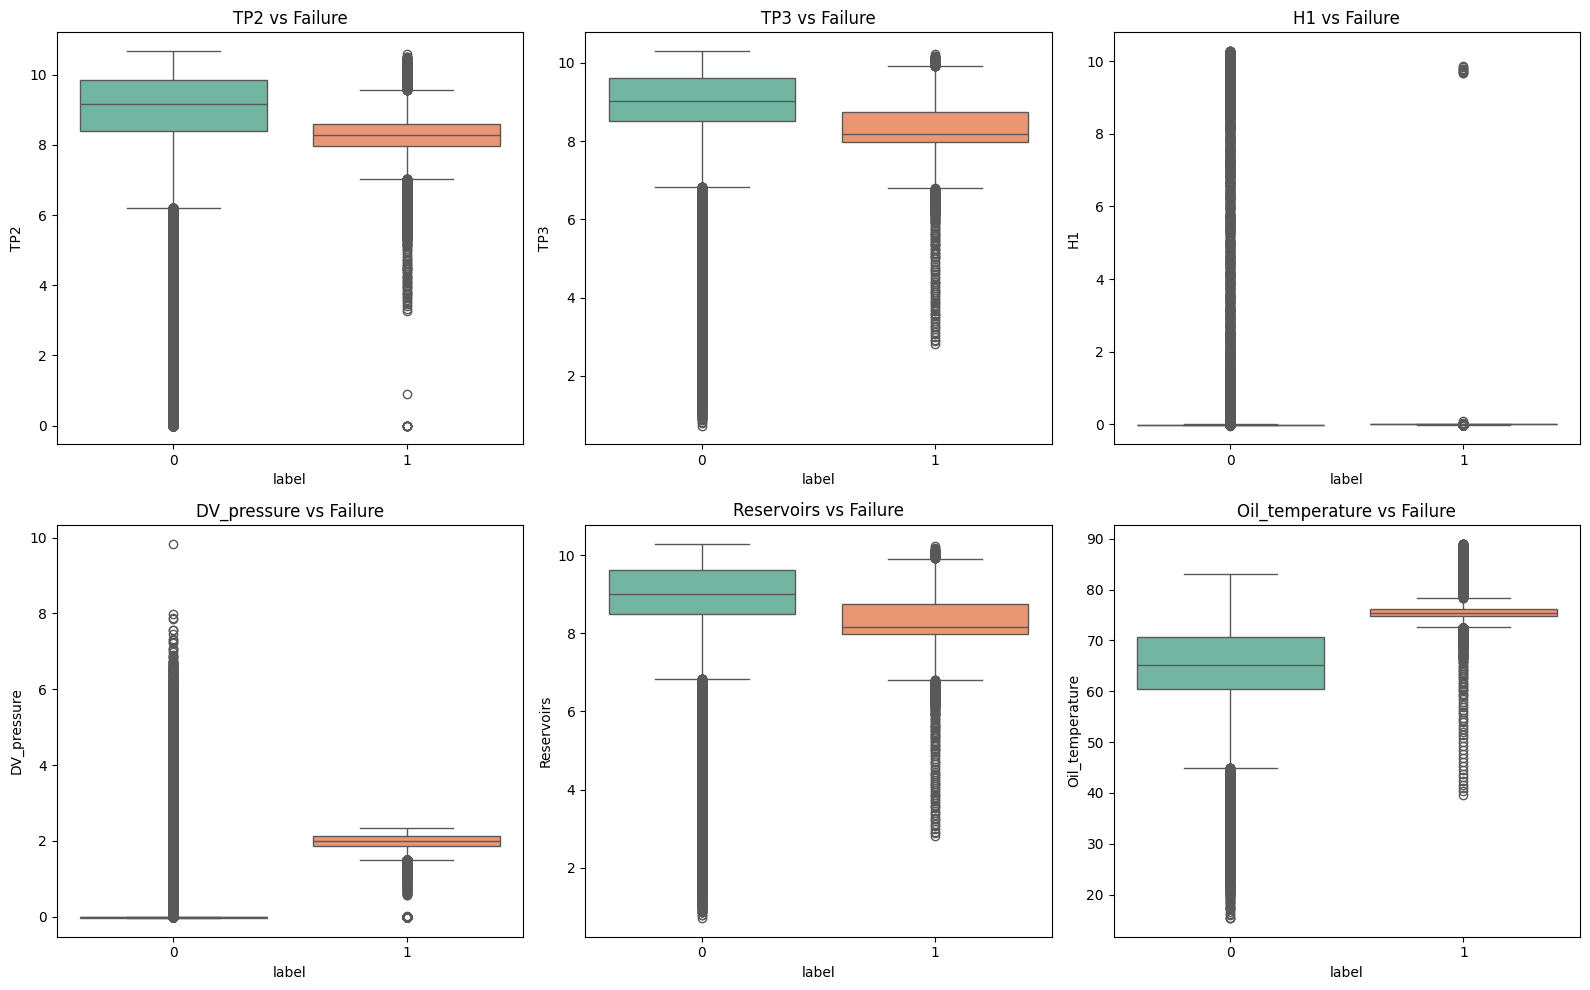

In [42]:
# Feature Distributions by Failure Label
# Boxplots
plt.figure(figsize=(16,10))
for i, col in enumerate(num_cols[:6]):  # first 6
    plt.subplot(2,3,i+1)
    sns.boxplot(x='label', y=col, data=df, palette='Set2')
    plt.title(f'{col} vs Failure')
plt.tight_layout()
plt.show()


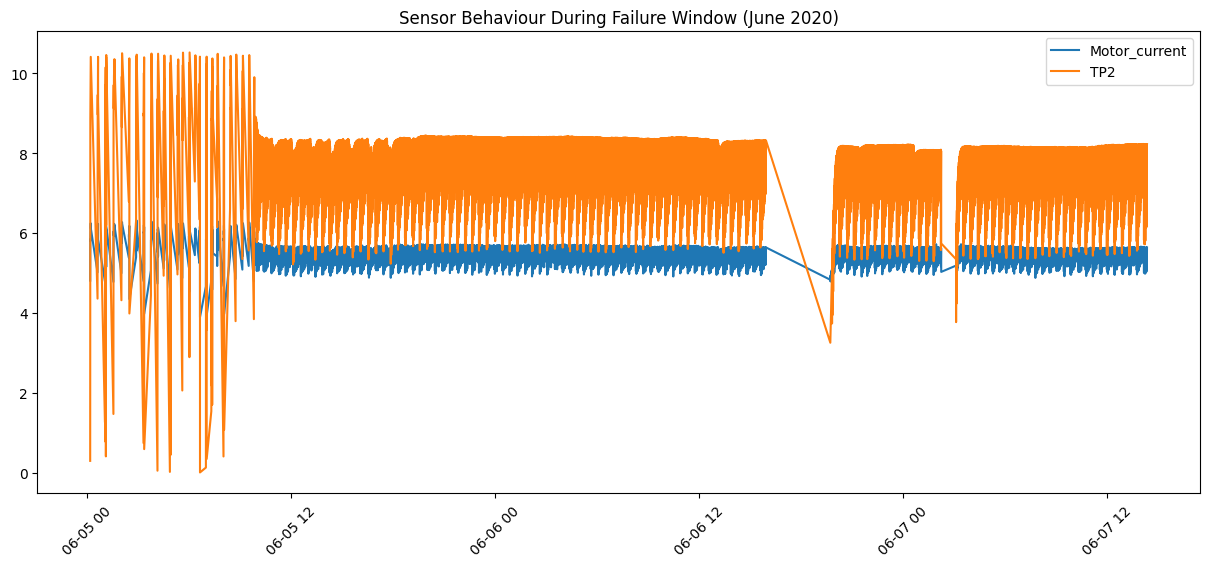

In [43]:
# Focusing on a failure window
fail_window = df[(df['timestamp'] > '2020-06-05') & (df['timestamp'] < '2020-06-08')]

plt.figure(figsize=(15,6))
plt.plot(fail_window['timestamp'], fail_window['Motor_current'], label='Motor_current')
plt.plot(fail_window['timestamp'], fail_window['TP2'], label='TP2')
plt.legend()
plt.title('Sensor Behaviour During Failure Window (June 2020)')
plt.xticks(rotation=45)
plt.show()


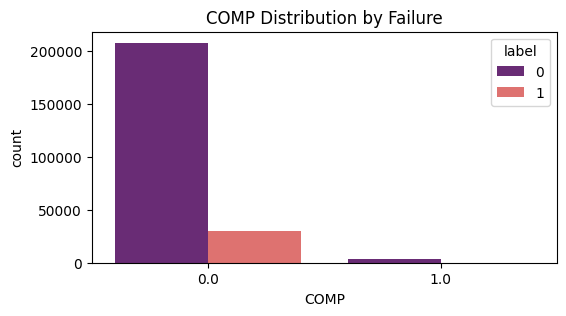

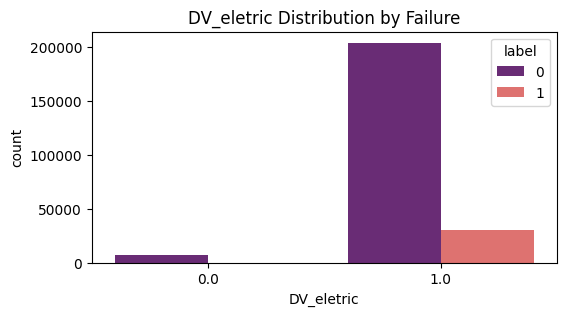

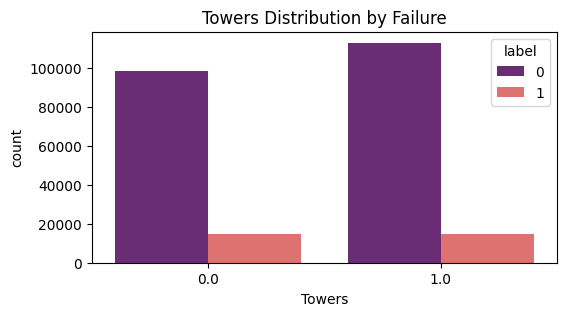

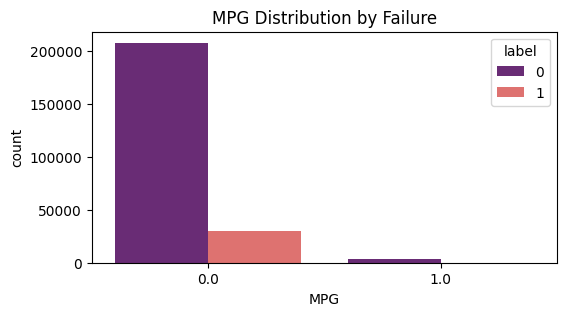

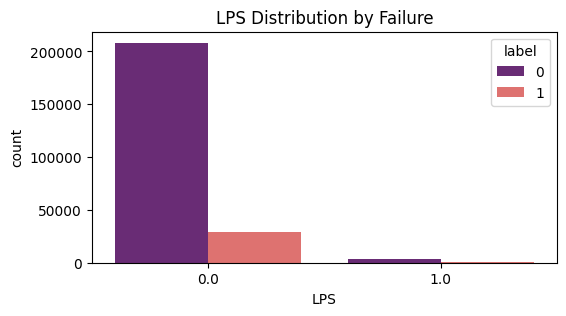

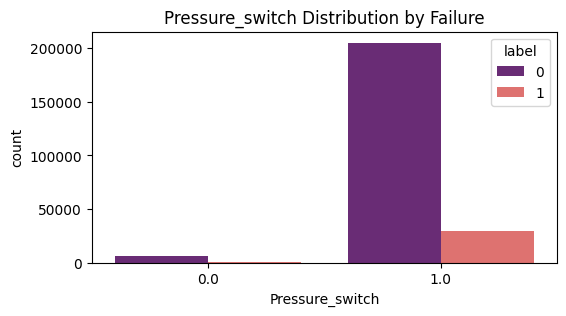

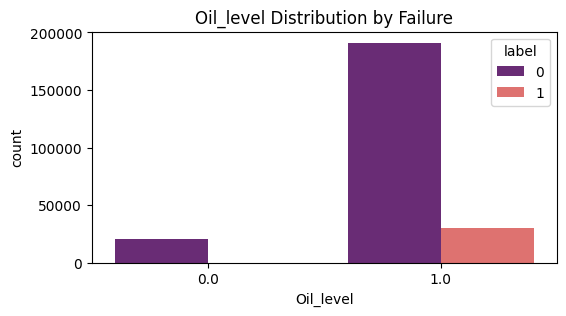

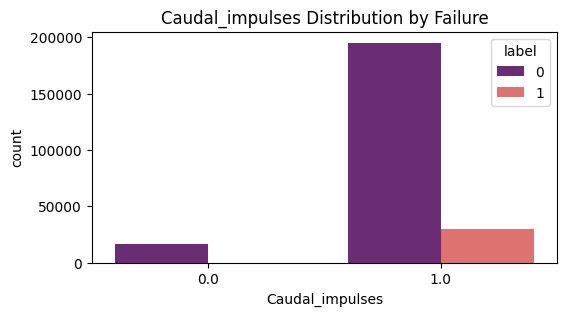

In [44]:
digital_cols = [col for col in df.columns if df[col].nunique() <= 3 and col not in ['label','Unnamed: 0']]

for col in digital_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue='label', data=df, palette='magma')
    plt.title(f'{col} Distribution by Failure')
    plt.show()


In [45]:
#Finalize Missing Value Handling
print(df.isnull().sum())


Unnamed: 0         0
timestamp          0
TP2                0
TP3                0
H1                 0
DV_pressure        0
Reservoirs         0
Oil_temperature    0
Motor_current      0
COMP               0
DV_eletric         0
Towers             0
MPG                0
LPS                0
Pressure_switch    0
label              0
Oil_level          0
Caudal_impulses    0
dtype: int64


In [46]:
# Extend each window by 24 hours on each side
from datetime import timedelta

extended_windows = [
    (pd.to_datetime(start) - timedelta(hours=24), pd.to_datetime(end) + timedelta(hours=24))
    for start, end in failure_windows
]

print("Extended Failure Windows:")
for win in extended_windows:
    print(win)

Extended Failure Windows:
(Timestamp('2020-04-17 00:00:00'), Timestamp('2020-04-19 23:59:59'))
(Timestamp('2020-05-28 23:30:00'), Timestamp('2020-05-31 06:00:00'))
(Timestamp('2020-06-04 10:00:00'), Timestamp('2020-06-08 14:30:00'))
(Timestamp('2020-07-14 14:30:00'), Timestamp('2020-07-16 19:00:00'))


In [47]:
df['label'] = 0  # reset labels
for start, end in extended_windows:
    mask = (df['timestamp'] >= start) & (df['timestamp'] <= end)
    df.loc[mask, 'label'] = 1

print("Failures after relabeling:", df['label'].sum())


Failures after relabeling: 38828


In [48]:
test_start = '2020-07-01'

train_df = df[df['timestamp'] < test_start]
test_df  = df[df['timestamp'] >= test_start]

X_train = train_df.drop(['label', 'Unnamed: 0', 'timestamp'], axis=1)
y_train = train_df['label']

X_test = test_df.drop(['label', 'Unnamed: 0', 'timestamp'], axis=1)
y_test = test_df['label']

print("Train failures:", y_train.sum())
print("Test failures:", y_test.sum())


Train failures: 33477
Test failures: 5351


In [49]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())


Class distribution after SMOTE:
label
0    146722
1    146722
Name: count, dtype: int64


In [50]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    eval_metric='auc'
)

model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [52]:
#making predictions
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


In [53]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95     55924
           1       0.11      0.01      0.01      5351

    accuracy                           0.91     61275
   macro avg       0.51      0.50      0.48     61275
weighted avg       0.84      0.91      0.87     61275

ROC-AUC: 0.5198600766095632


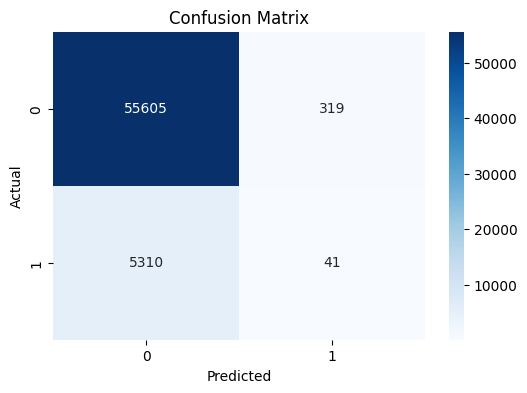

In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


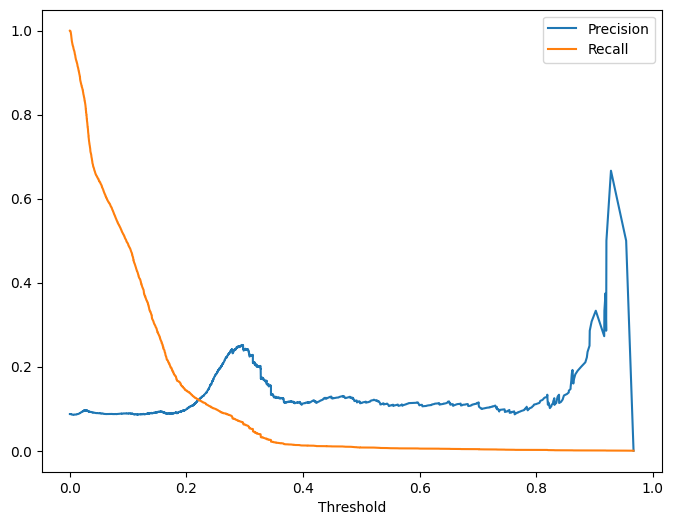

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     55924
           1       0.10      0.14      0.12      5351

    accuracy                           0.81     61275
   macro avg       0.51      0.51      0.51     61275
weighted avg       0.84      0.81      0.83     61275



In [55]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot PR curve to find best threshold
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

# Try a lower threshold (e.g., 0.2)
threshold = 0.2
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))


In [56]:
thresholds = np.arange(0.05, 0.6, 0.05)
for t in thresholds:
    y_pred_adj = (y_pred_proba >= t).astype(int)
    print(f"Threshold: {t}")
    print(classification_report(y_test, y_pred_adj, digits=3))


Threshold: 0.05
              precision    recall  f1-score   support

           0      0.916     0.372     0.529     55924
           1      0.089     0.643     0.157      5351

    accuracy                          0.395     61275
   macro avg      0.503     0.507     0.343     61275
weighted avg      0.844     0.395     0.496     61275

Threshold: 0.1
              precision    recall  f1-score   support

           0      0.914     0.517     0.661     55924
           1      0.089     0.492     0.150      5351

    accuracy                          0.515     61275
   macro avg      0.501     0.504     0.405     61275
weighted avg      0.842     0.515     0.616     61275

Threshold: 0.15000000000000002
              precision    recall  f1-score   support

           0      0.914     0.730     0.812     55924
           1      0.092     0.285     0.139      5351

    accuracy                          0.691     61275
   macro avg      0.503     0.508     0.475     61275
weighted avg

In [58]:
#Locking threshold at 0.05 and evaluating in detail
best_threshold = 0.05
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.92      0.37      0.53     55924
           1       0.09      0.64      0.16      5351

    accuracy                           0.40     61275
   macro avg       0.50      0.51      0.34     61275
weighted avg       0.84      0.40      0.50     61275

[[20787 35137]
 [ 1909  3442]]


In [59]:
#Fine-tuning the threshold using a custom metric
from sklearn.metrics import fbeta_score
import numpy as np

thresholds = np.arange(0.01, 0.5, 0.01)
best_thresh, best_f2 = 0, 0

for t in thresholds:
    y_pred_t = (y_pred_proba >= t).astype(int)
    f2 = fbeta_score(y_test, y_pred_t, beta=2)  # F2 prioritizes recall
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

print(f"Best threshold = {best_thresh}, F2 = {best_f2:.3f}")


Best threshold = 0.02, F2 = 0.323


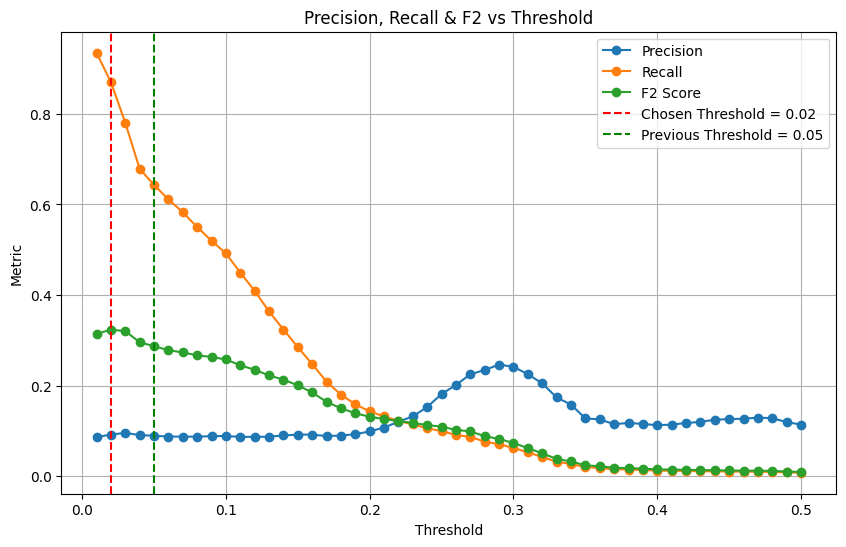

In [60]:
#Precision, Recall, F2 vs Threshold Plot
import numpy as np
from sklearn.metrics import precision_score, recall_score, fbeta_score

thresholds = np.arange(0.01, 0.51, 0.01)
precisions, recalls, f2_scores = [], [], []

for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f2_scores.append(fbeta_score(y_test, y_pred_thresh, beta=2, zero_division=0))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f2_scores, label='F2 Score', marker='o')

plt.axvline(0.02, color='red', linestyle='--', label='Chosen Threshold = 0.02')
plt.axvline(0.05, color='green', linestyle='--', label='Previous Threshold = 0.05')

plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('Precision, Recall & F2 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [68]:
import shap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Use 'Agg' backend for headless plot saving
matplotlib.use('Agg')

# Init SHAP JS (for force plot HTML)
shap.initjs()

# ========== Model Explainer ==========
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_res)

# ========== Base Probability ==========
print(f"🔹 Base failure probability (expected value): {explainer.expected_value:.4f}")

# ========== Overall Top 10 Features ==========
shap_abs = np.abs(shap_values).mean(axis=0)
top_features = np.argsort(shap_abs)[-10:]

X_top = X_train_res.iloc[:, top_features]
shap_top = shap_values[:, top_features]

# ----- Bar Plot (All Classes) -----
shap.summary_plot(shap_top, X_top, plot_type="bar", show=False)
plt.title("Top 10 Features (Mean SHAP Impact)")
plt.tight_layout()
plt.savefig("shap_top10_bar.png", dpi=300)
plt.close()
print("SHAP bar plot (all classes): shap_top10_bar.png")

# ----- Distribution Plot (All Classes) -----
shap.summary_plot(shap_top, X_top, show=False)
plt.title("Top 10 Features Impact Distribution")
plt.tight_layout()
plt.savefig("shap_top10_distribution.png", dpi=300)
plt.close()
print("SHAP distribution plot (all classes): shap_top10_distribution.png")

# ----- Force Plot (First Prediction) -----
i = 0
force_plot = shap.force_plot(
    explainer.expected_value, shap_values[i, top_features], X_train_res.iloc[i, top_features]
)
shap.save_html("shap_force_plot.html", force_plot)
print("Force plot saved: shap_force_plot.html (open in browser)")

# ========== Failure-Only Top Features ==========
shap_fail = shap_values[y_train_res == 1]
X_fail = X_train_res[y_train_res == 1]

shap_abs_fail = np.abs(shap_fail).mean(axis=0)
top_features_fail = np.argsort(shap_abs_fail)[-10:]

X_fail_top = X_fail.iloc[:, top_features_fail]
shap_fail_top = shap_fail[:, top_features_fail]

# ----- Bar Plot (Failures Only) -----
shap.summary_plot(shap_fail_top, X_fail_top, plot_type="bar", show=False)
plt.title("Top 10 Features Driving Failures (Label = 1)")
plt.tight_layout()
plt.savefig("shap_top10_failures_bar.png", dpi=300)
plt.close()
print("SHAP bar plot (failures only): shap_top10_failures_bar.png")

# ----- Distribution Plot (Failures Only) -----
shap.summary_plot(shap_fail_top, X_fail_top, show=False)
plt.title("Impact Distribution (Failures Only)")
plt.tight_layout()
plt.savefig("shap_top10_failures_distribution.png", dpi=300)
plt.close()
print("SHAP distribution plot (failures only): shap_top10_failures_distribution.png")

# ========== Print Top Feature Summary ==========
print("\n Text Summary (All Samples):")
for idx in reversed(top_features):
    fname = X_train_res.columns[idx]
    print(f" - {fname}: {shap_abs[idx]:.4f} (mean |SHAP|)")

print("\n Text Summary (Failures Only):")
for idx in reversed(top_features_fail):
    fname = X_train_res.columns[idx]
    print(f" - {fname}: {shap_abs_fail[idx]:.4f} (mean |SHAP| for failures)")


🔹 Base failure probability (expected value): 0.0082
SHAP bar plot (all classes): shap_top10_bar.png
SHAP distribution plot (all classes): shap_top10_distribution.png
Force plot saved: shap_force_plot.html (open in browser)
SHAP bar plot (failures only): shap_top10_failures_bar.png
SHAP distribution plot (failures only): shap_top10_failures_distribution.png

 Text Summary (All Samples):
 - DV_pressure: 2.2104 (mean |SHAP|)
 - Oil_temperature: 1.4443 (mean |SHAP|)
 - H1: 0.6587 (mean |SHAP|)
 - TP3: 0.6423 (mean |SHAP|)
 - Reservoirs: 0.4787 (mean |SHAP|)
 - Caudal_impulses: 0.3402 (mean |SHAP|)
 - TP2: 0.1901 (mean |SHAP|)
 - Motor_current: 0.1098 (mean |SHAP|)
 - LPS: 0.0559 (mean |SHAP|)
 - Oil_level: 0.0257 (mean |SHAP|)

 Text Summary (Failures Only):
 - DV_pressure: 2.9342 (mean |SHAP| for failures)
 - Oil_temperature: 1.7454 (mean |SHAP| for failures)
 - H1: 0.9316 (mean |SHAP| for failures)
 - TP3: 0.6671 (mean |SHAP| for failures)
 - Reservoirs: 0.5448 (mean |SHAP| for failures)

In [ ]:
#DV_pressure is the most critical variable for failure prediction — its SHAP value is nearly 3x more impactful than most other features.

#Oil_temperature is another strong influencer — especially in failure cases.

#Features like H1, TP3, and Reservoirs contribute moderately.

#Features like Oil_level, Towers have minimal effect and may be considered for feature reduction unless needed for domain reasons.

In [94]:


THRESHOLD = 0.02


def predict_failures_with_text_explanations(model, input_data: pd.DataFrame, output_dir="output"):
    import os
    os.makedirs(output_dir, exist_ok=True)

    predictions = model.predict(input_data)
    proba = model.predict_proba(input_data)[:, 1]

    # SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(input_data)

    explanations = []

    for i in range(len(input_data)):
        sample_features = input_data.iloc[[i]]
        sample_shap = shap_values[i].flatten()

        # Get top 5 features by absolute SHAP value
        feature_importance = sorted(
            zip(input_data.columns, sample_shap, sample_features.values.flatten()),
            key=lambda x: abs(x[1]), reverse=True
        )[:5]

        failure_prob = proba[i]
        label = 'FAILURE' if predictions[i] == 1 else 'NORMAL'

        explanation = f"Row {i}: The model predicts **{label}** with a probability of **{failure_prob:.2f}**.\n\n"
        
        if label == 'FAILURE':
            explanation += "The following features contributed most to this failure prediction:\n"
        else:
            explanation += "The following features helped predict a normal condition:\n"

        for rank, (name, shap_val, actual_val) in enumerate(feature_importance, start=1):
            direction = "increased" if shap_val > 0 else "decreased"
            effect = "risk of failure" if shap_val > 0 else "chance of normal operation"
            explanation += (
                f"{rank}. **{name}** (value = {actual_val:.2f}) {direction} the model's prediction towards **{effect}**.\n"
            )

        # Optional summary
        top_feature = feature_importance[0]
        summary_statement = (
            f"\n The feature **{top_feature[0]}** played the most significant role in the model's prediction. "
            f"This suggests that its value ({top_feature[2]:.2f}) is highly indicative of a **{label.lower()}** in this case.\n"
        )
        explanation += summary_statement

        explanations.append(explanation)

    # Save explanations to individual text files
    for i, exp in enumerate(explanations):
        with open(os.path.join(output_dir, f"explanation_row_{i}.txt"), "w") as f:
            f.write(exp)

    return predictions, explanations




In [ ]:
def test_prediction(model, test_sample: pd.DataFrame):
    print("Running test prediction...")
    results, explanations = predict_failures_with_text_explanations(
        model, test_sample, output_dir="test_output"
    )

    # Showing first explanation
    print("\n--- First Prediction Explanation ---")
    print(explanations[0])
    return results


In [107]:


# Sample input 
test_sample = pd.DataFrame([{
    'LPS': 12.5,
    'MPG': 3.7,
    'COMP': 8.0,
    'Motor_current': 14.2,
    'Oil_temperature': 85.0,
    'TP2': 5.5,
    'TP3': 6.3,
    'H1': 1.1,
    'DV_pressure': 7.8,
    'Reservoirs': 2.2,
    'DV_eletric': 3.5,
    'Towers': 4.0,
    'Pressure_switch': 0.9,
    'Oil_level': 6.6,
    'Caudal_impulses': 9.1
}])


# Fix: reordering to match model input
test_sample = test_sample[X_train.columns]


# Running prediction + explanation
test_prediction(model, test_sample)



Running test prediction...

--- First Prediction Explanation ---
Row 0: The model predicts **FAILURE** with a probability of **0.61**.

The following features contributed most to this failure prediction:
1. **COMP** (value = 8.00) increased the model's prediction towards **risk of failure**.
2. **Motor_current** (value = 14.20) decreased the model's prediction towards **chance of normal operation**.
3. **DV_eletric** (value = 3.50) decreased the model's prediction towards **chance of normal operation**.
4. **Towers** (value = 4.00) increased the model's prediction towards **risk of failure**.
5. **MPG** (value = 3.70) decreased the model's prediction towards **chance of normal operation**.

 The feature **COMP** played the most significant role in the model's prediction. This suggests that its value (8.00) is highly indicative of a **failure** in this case.



array([1])

In [ ]:
import pickle

THRESHOLD = 0.02

# Bundling final model and metadata
model_bundle = {
    "model": model,
    "threshold": THRESHOLD,
    "feature_names": X_train_res.columns.tolist()
}

# Saving to file
with open("machine_failure_model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

print("Final model saved.")


Final model saved.
